### Research course submission

**Name:** Abhijith Babu

**Paper:** Axiomatic Attribution for Deep Networks

# Integrated Gradients for attribution of input features of a deep neural network

In this set of experiments, I try to use integrated gradients to find the attribution of input features for a deep neural networks for classification.

This method is better than other methods (like the method tried in last assignment) because it follows the following axioms

1. **Sensitivity** - If an input which is different from base input by one feature has a change in class score, then that feature has a positive attribution

2. **Implementation invariance** - The attribution of a feature is independent of the implemented structure of the neural network

3. **Linearity** - If 2 networks are linearly combined, the attributions should also be linearly combined

4. **Completeness** - The sum of attribution of all features should be the difference between the class score of base input and actual input

# Integrated gradients

Integrated gradients calculate the gradients for a path between the original input and base input. The gradients across the path are then integrated for finding the attribute.

The straight line between input (x) and base input (x') takes the form

x(t) = x' + t(x - x') , t = [0,1]

To find the gradient, differentiate the class score F(x) with each points in the above line.

Now the gradients are integrated from t = 0 to t = 1 to get the attribution values



# Integrated gradients for image classification

### Approach

Load a pretrained model (VGG19 from pytorch).

For an input image, generate a base image (black on all pixels).

Split the line between the base image and the input image into large number of parts and find the image for each of the split.

Compute gradients for each of the split images using backpropagation.

Sum the gradients to find the integrated gradient value as the attribute.

Plot the results.

In [ ]:
# Importing the necessary libraries

import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import contextlib
import os
import torchvision.transforms as transforms
import numpy as np
from tqdm import tqdm
import threading

In [ ]:
# Loading and understanding the vgg19 model

model = models.vgg19(pretrained=True)
with open(os.devnull, 'w') as fnull:
    with contextlib.redirect_stdout(fnull):
        model.eval()


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Images used in this experiment

images = [
    ["images/hen.jpg", 8],
    ["images/cup.jpg", 968],
    ["images/hammer.jpg", 587],
    ["images/violin.jpg", 889]
]

In [ ]:
image_size = 224 # length/width of the images in this experiment

In [ ]:
# Creating a dictionary tp store attributions (easy for multiple threads to access together)
attribution_dict = {}
for i in range(len(images)):
    attribution_dict[i] = [None]*image_size

In [ ]:
# Creating a function to compute the integrated gradients

def integrate_gradients(gradients, steps, row, col, image):
    gradient_sum = 0
    for i in range(steps+1):
        gradient_sum += gradients[i].abs().mean(dim=1)[0,row,col]
    integrated_gradients = (gradient_sum*(image[0].mean(dim=0)[row,col]))/steps
    return integrated_gradients.item()


In [ ]:
# Creating a function to populate rows in the attribution. Useful in multithreading

def add_rows(gradient, steps, row, index, image):
    row_gradient = []
    for col in range(image_size):
        row_gradient.append(integrate_gradients(gradient, steps, row, col, image))
    attribution_dict[index][row] = row_gradient

In [ ]:
# Function to generate integrated gradients and plot it

def generate_gradient(img, index):
    img_path = img[0]
    class_number = img[1]

    # Storing original image for plotting in the end
    original_image = Image.open(img_path)
    image = original_image

    # Preprocessing the image
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
    ])
    image = transform(image)
    image = image.unsqueeze(0)
    image = image.requires_grad_()

    base_image = 0*image # Black image of size same as input.

    line_grads = [] # For storing all the gradients in the line
    steps = 50 # Number of steps in the line

    # Calculating gradients at each step in the line
    for i in tqdm(range(steps+1)):
        t = i/steps
        new_image = base_image + (image-base_image) * t # Equation of the line
        new_image.retain_grad()
        class_scores = model(new_image)
        target_score = class_scores[0, class_number]
        model.zero_grad() # setting gradients to zero
        target_score.backward(retain_graph=True)
        line_grads.append(new_image.grad.data)

    # Looping through all the pixels to calculate the attribution
    for row in tqdm(range(image_size)):
        add_rows(line_grads, steps, row, index, image)

    attribution = attribution_dict[index]

    # Normalizing the attribution to range [0, 255]
    attribution = np.array(attribution, dtype=np.float32)
    attribution = ((attribution - np.min(attribution))*255)//(np.max(attribution)-np.min(attribution))
    attribution = np.array(attribution, dtype=np.uint8)

    plt.subplot(len(images), 2, (index*2)+1)
    plt.title("Original Image")
    plt.imshow(original_image, cmap="gray")
    plt.axis("off")

    attr_image = Image.fromarray(attribution)
    plt.subplot(len(images), 2, (index*2)+2)
    plt.title("Integrated Gradients")
    plt.imshow(attr_image, cmap="gray")
    plt.axis("off")




100%|██████████| 224/224 [08:44<00:00,  2.34s/it]


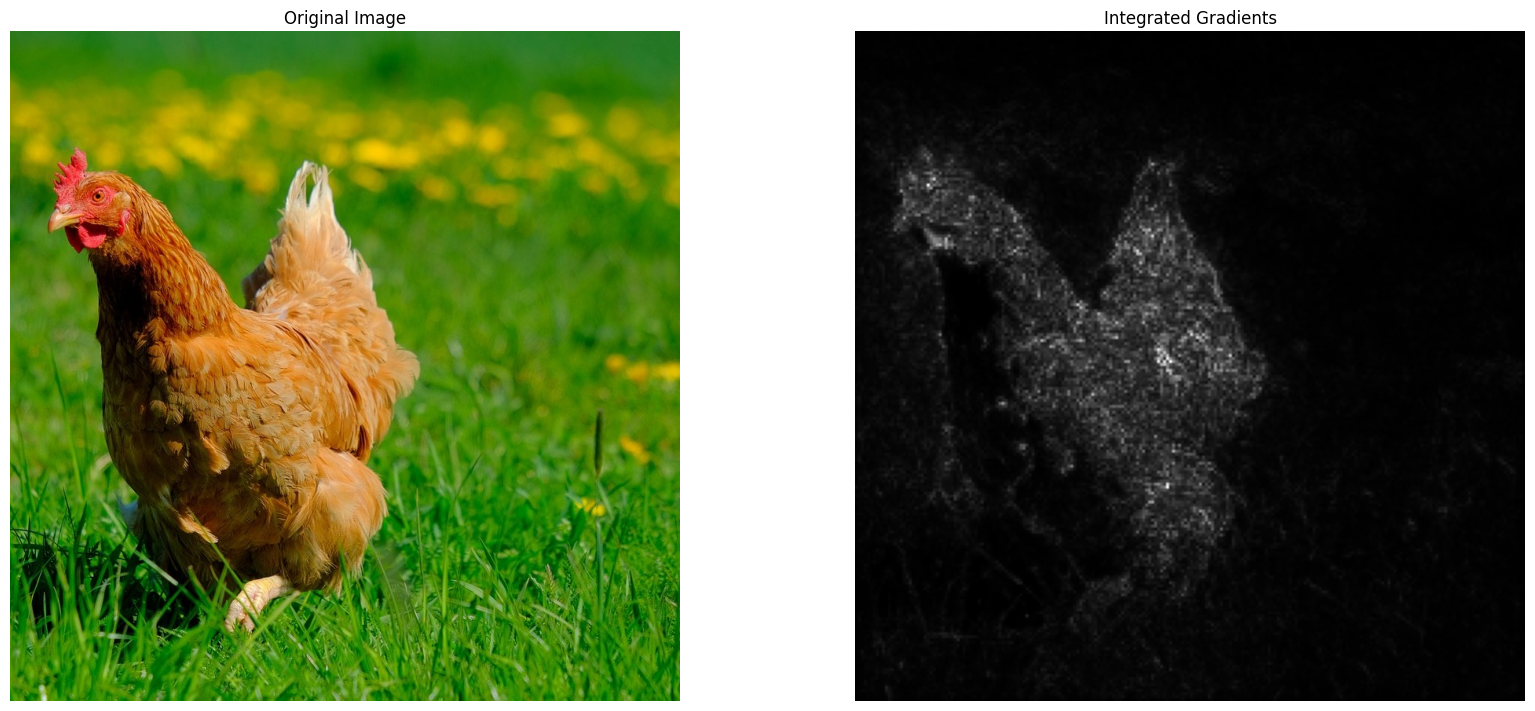

100%|██████████| 224/224 [08:14<00:00,  2.21s/it]


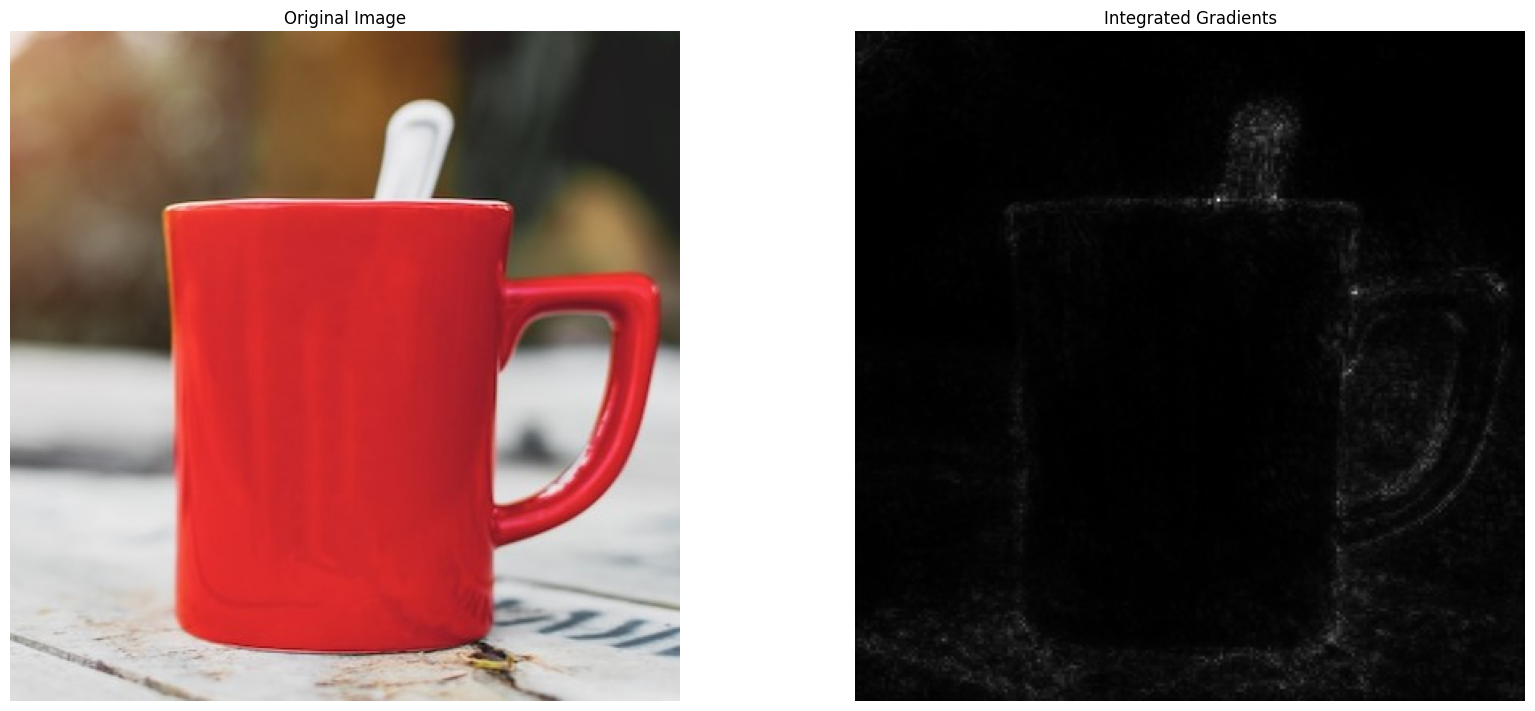

100%|██████████| 224/224 [09:26<00:00,  2.53s/it]


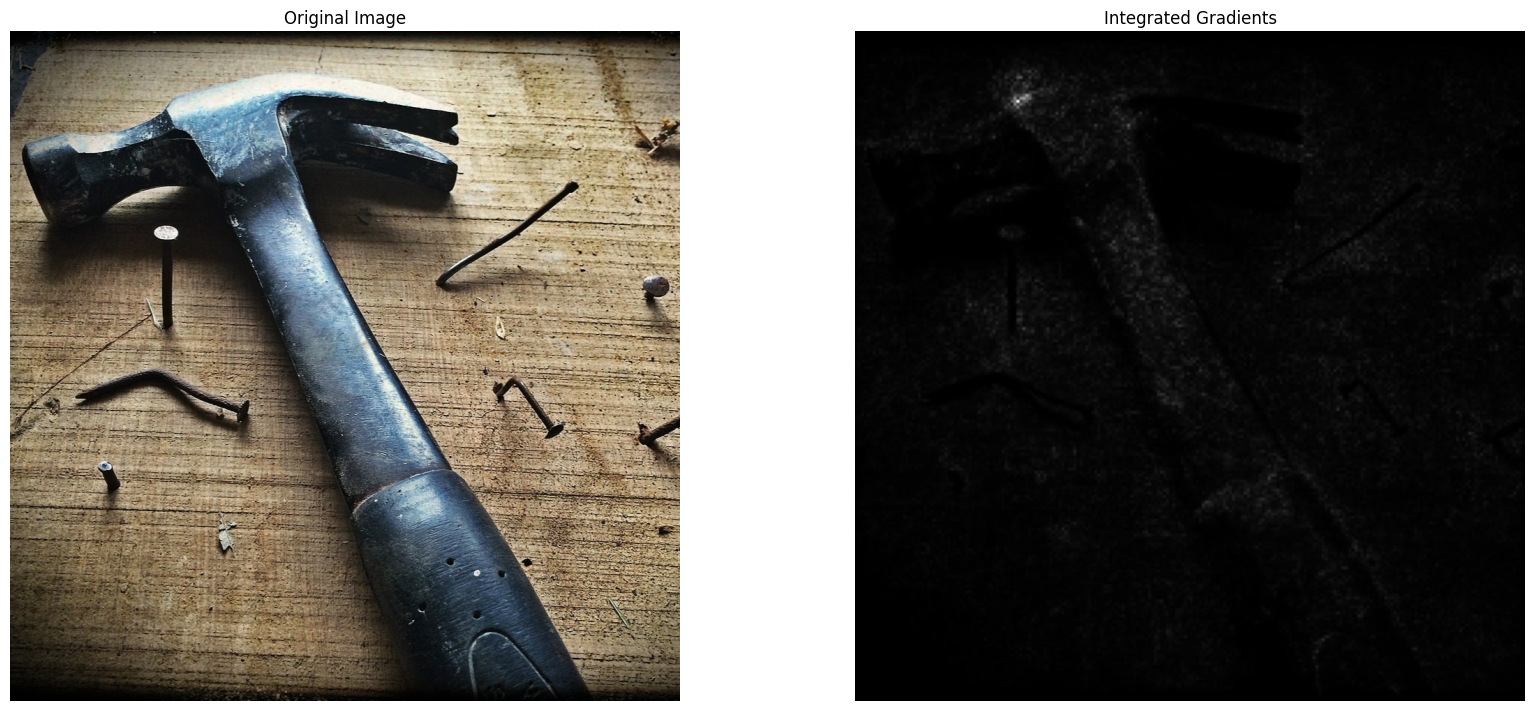

100%|██████████| 224/224 [09:23<00:00,  2.51s/it]


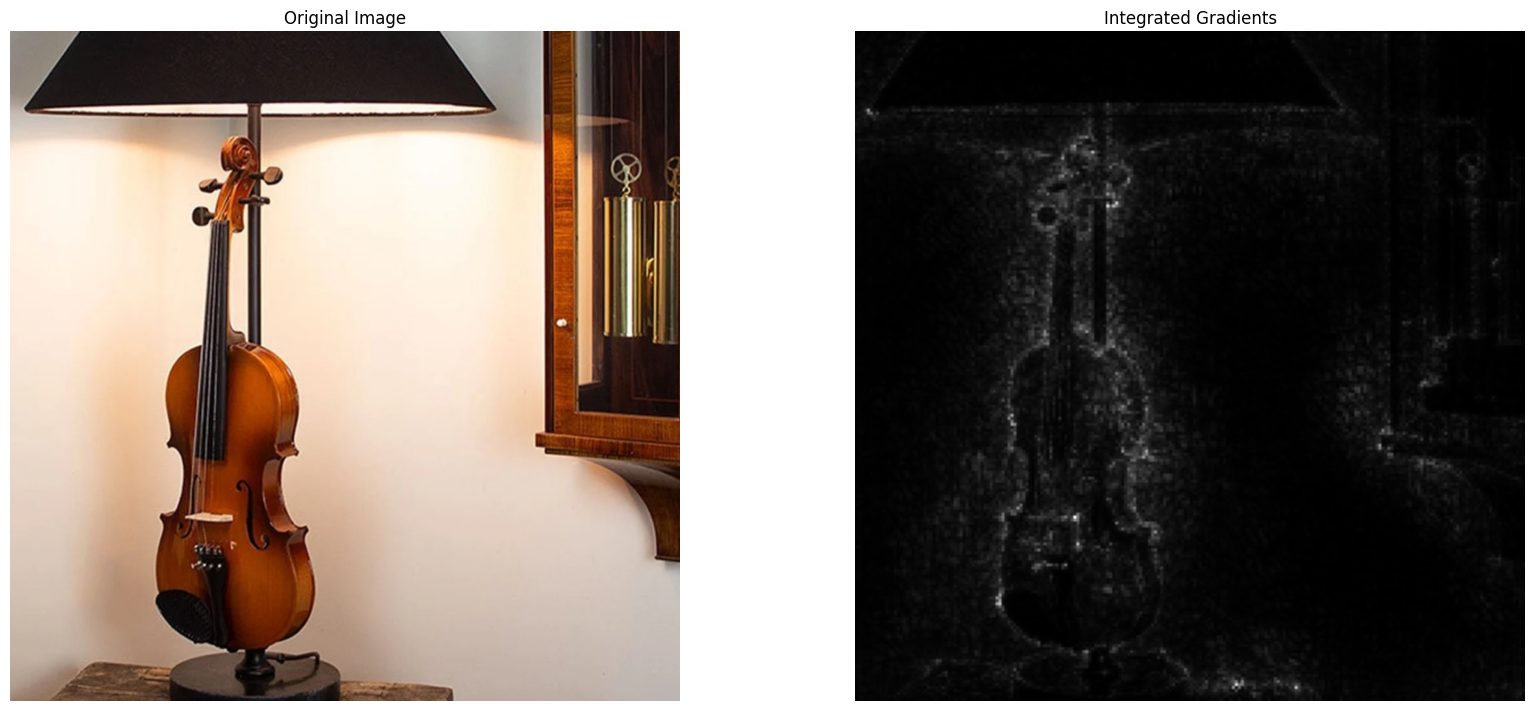

In [ ]:
# Creating integrated gradients parallelly using multiple threads
for img_e in enumerate(images):
    index = img_e[0]
    img = img_e[1]
    plt.figure(figsize=(20, 40))
    thread = threading.Thread(target=generate_gradient,args=(img,index))
    thread.start()
    thread.join()
    plt.show()

# Integrated gradients for text analysis

Here I attempt to use integrated gradients to explain how a neural network analyses natural language texts. My aim is to find the tokens in the text that contributed more to the model's output.

Here I am using the 'bart-large-mnli' model by facebook. The model takes a premise and a hypothesis as the input and identifies whether the hypothesis follows the premise, contradicts it, or is unrelated.

### Approach

Take a premise and hypothesis as strings.

Convert them to vectorized tokens

Define base texts.

Interpolate the line between the input and base and choose n points.

for the n points

- Pass the tokens into the model and calculate the class scores for the three classes (entailment, contradiction, neutral)

- Backpropagate the class_score of the target class to get the gradient.

integrate the gradients for all the points.

plot the results


In [1]:
# Importing the libraries

import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from tqdm import tqdm
import contextlib
import os

C:\Users\abhij\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Loading the model and tokenizer

model_name = "facebook/bart-large-mnli"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Setting the model to evaluation mode
with open(os.devnull, 'w') as fnull:
    with contextlib.redirect_stdout(fnull):
        model.eval()

In [3]:
# Finding the class labels of the model

print(model.config.id2label)

{0: 'contradiction', 1: 'neutral', 2: 'entailment'}


In [20]:
# Defining the input texts

premise = "I like red fruits like cherries. Apple is round and red."
hypothesis = "I hate to have an apple in the morning"

In [21]:
# Since our hypothesis is a contradiction, setting the target class accordingly

target_class = 0

In [22]:
# Vectorizing the text

input_vectors = tokenizer(premise, hypothesis, return_tensors="pt")
input_vectors = input_vectors["input_ids"]

In [23]:
# Finding the index of the general tokens like <s> and </s>. We need to keep them as it is in the base input.

lock_index = []
for index, val in enumerate(input_vectors[0]):
  print(index,val,tokenizer.decode(val))
  if val.item() in [0,2]:
    lock_index.append(index)

0 tensor(0) <s>
1 tensor(100) I
2 tensor(101)  like
3 tensor(1275)  red
4 tensor(12849)  fruits
5 tensor(101)  like
6 tensor(30379)  cher
7 tensor(4458) ries
8 tensor(4) .
9 tensor(1257)  Apple
10 tensor(16)  is
11 tensor(1062)  round
12 tensor(8)  and
13 tensor(1275)  red
14 tensor(4) .
15 tensor(2) </s>
16 tensor(2) </s>
17 tensor(100) I
18 tensor(4157)  hate
19 tensor(7)  to
20 tensor(33)  have
21 tensor(41)  an
22 tensor(15162)  apple
23 tensor(11)  in
24 tensor(5)  the
25 tensor(662)  morning
26 tensor(2) </s>


### Creating a base input

The above description shows the value of each token in the vector. The general tokens like start and end of string ```<s>``` and ```</s>``` has to be preserved in the base input as well.

For the base input, rest of the tokens can be replaced with a neutral word 'the'. The vector value for 'the' is 5 as seen below.

In [24]:
# Finding the token for 'the'
tokenizer.encode(' the')[1]

5

In [25]:
# Generating the base input
base_list = [5]*input_vectors.shape[1]

# Modifying the positions of <s> and </s>
for index in lock_index:
  base_list[index] = input_vectors[0][index]
base_input = torch.tensor([base_list], dtype=torch.int)


In [26]:
print(base_input)

tensor([[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 5, 5, 5, 5, 5, 5, 5,
         5, 5, 2]], dtype=torch.int32)


In [27]:
# Interpolating and finding intermediate vectors

intermediate_vectors = []
steps = 50

for i in range(steps+1):
    new_vector = base_input + ((input_vectors-base_input) * i)//steps
    intermediate_vectors.append(new_vector)


In [ ]:
# Calculating gradients for all the points in the line

gradient_list = []
for i in tqdm(intermediate_vectors):

    model.zero_grad()

    # generating embeddings of the inputs for forward and backward pass
    embedding_layer = model.model.shared
    embeddings = embedding_layer(i)
    embeddings.requires_grad_()
    embeddings.retain_grad()

    # Forward pass of embeddings
    output = model.model.encoder(inputs_embeds=embeddings, return_dict=True)

    # getting the class score
    class_logits = model.classification_head(output.last_hidden_state[:, 0, :])
    class_score = class_logits[0, target_class]

    # Backpropagation
    class_score.backward()

    # Taking sum of gradient of all vector elements to be the gradient of the token
    gradient = embeddings.grad
    gradient = gradient.sum(dim=2)
    gradient_list.append(gradient)

100%|██████████| 51/51 [00:49<00:00,  1.04it/s]


In [28]:
# Integrating the gradients

gradient_sum = sum(gradient_list)*(input_vectors-base_input)
gradient_sum = gradient_sum/steps
integrated_gradients = gradient_sum.tolist()[0]

In [29]:
# normalizing the integrated gradients to range of [0,255] (for color printing)

normalized_ig = []
for i in integrated_gradients:
  normalized_ig.append((i-min(integrated_gradients))*255/(max(integrated_gradients)-min(integrated_gradients)))

In [30]:
# Displaying the input texts color coded with integrated gradient values

html_string = ""
for i in range(len(normalized_ig)):
  # Skipping the general tokens
  if input_vectors[0][i] in [0,2]:
    continue
  # Printing words color coded with integrated gradients using html tags
  word = f"<span style = 'color:rgb(0,{normalized_ig[i]},0)'> {tokenizer.decode(input_vectors[0][i])} </span>"
  html_string += word
from IPython.core.display import display, HTML
display(HTML(html_string))

Here we can see that the words 'fruit' and 'apple' have more contribution to the output of the model from the html colors (More green -> high attribution)